### Homework 4 Appendix

In [128]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.datasets import get_rdataset
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from ISLP import load_data
from sklearn.cluster import \
     (KMeans,
      AgglomerativeClustering)
from scipy.cluster.hierarchy import \
     (dendrogram,
      cut_tree)
from ISLP.cluster import compute_linkage
from sklearn.metrics import confusion_matrix
np.random.seed(2)
import seaborn as sns

### 1.0 Load and Process Dataset

In [129]:
# Load the dataset
#phishingurl_data = pd.read_csv("PhiUSIIL_Phishing_URL_Dataset.csv")
phishingurl_data = pd.read_csv("C:\\Users\\david\\Downloads\\phiusiil+phishing+url+dataset\\PhiUSIIL_Phishing_URL_Dataset.csv")

In [130]:
phishingurl_data.head()

,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.0,1.000000,0.522907,...,0,0,1,34,20,28,119,0,124,1
1,31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.0,0.666667,0.032650,...,0,0,1,50,9,8,39,0,217,1
2,597387.txt,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.0,0.866667,0.028555,...,0,0,1,10,2,7,42,2,5,1
3,554095.txt,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.0,1.000000,0.522907,...,1,1,1,3,27,15,22,1,31,1
4,151578.txt,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.0,1.000000,0.079963,...,1,0,1,244,15,34,72,1,85,1


### 1.1 Check for Missing Values

In [131]:
phishingurl_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235795 entries, 0 to 235794
Data columns (total 56 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   FILENAME                    235795 non-null  object 
 1   URL                         235795 non-null  object 
 2   URLLength                   235795 non-null  int64  
 3   Domain                      235795 non-null  object 
 4   DomainLength                235795 non-null  int64  
 5   IsDomainIP                  235795 non-null  int64  
 6   TLD                         235795 non-null  object 
 7   URLSimilarityIndex          235795 non-null  float64
 8   CharContinuationRate        235795 non-null  float64
 9   TLDLegitimateProb           235795 non-null  float64
 10  URLCharProb                 235795 non-null  float64
 11  TLDLength                   235795 non-null  int64  
 12  NoOfSubDomain               235795 non-null  int64  
 13  HasObfuscation

There appears to be no missing values in the dataset.  We believe this is because the URLs were gathered by a program and if an item wasn't present on the website, like a password field, the program appropriately labeled it as a 0.

### 1.2 Check the Mean and Variance for Scaling

In [132]:
# There are too many records for these scripts to run in a reasonable amount of time
# So, we take a random sample of 5000 records
url_sample = phishingurl_data.sample(5000, random_state=13)

# Set index equal to the domain field
url_sample.set_index('URL', inplace=True)

# Drop text fields: Filename, URL, TLD, Title
url_sample_data = url_sample.drop(['FILENAME', 'Domain', 'TLD', 'Title'],axis = 1)

In [133]:
url_sample_data.head()

,URLLength,DomainLength,IsDomainIP,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,HasObfuscation,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
URL,,,,,,,,,,,,,,,,,,,,,
https://www.comercustombuilders.com,34,27,0,100.000000,1.0,0.522907,0.063880,3,1,0,...,1,0,0,23,4,16,18,0,13,1
https://www.marvell.com,22,15,0,100.000000,1.0,0.522907,0.062975,3,1,0,...,0,0,1,32,7,10,142,0,18,1
http://www.globalstatupdate.com,31,24,0,75.642857,1.0,0.522907,0.058841,3,1,0,...,0,0,0,0,0,0,0,0,0,0
https://www.snoeps.nl,20,13,0,100.000000,1.0,0.008200,0.063324,2,1,0,...,1,1,1,14,5,12,19,2,22,1
https://papainoelexiste.com/3f72c3dbb5215da939b7a2e90/product/sku1670963233?e=1670993043,87,19,0,15.266204,1.0,0.522907,0.030750,3,0,0,...,1,0,1,1,1,0,1,0,1,0


In [134]:
# Check the Mean
url_sample_data.mean()

URLLength                        34.165200
DomainLength                     21.242800
IsDomainIP                        0.003600
URLSimilarityIndex               78.814404
CharContinuationRate              0.847829
TLDLegitimateProb                 0.257006
URLCharProb                       0.055631
TLDLength                         2.768600
NoOfSubDomain                     1.153800
HasObfuscation                    0.001200
NoOfObfuscatedChar                0.008400
ObfuscationRatio                  0.000087
NoOfLettersInURL                 19.100800
LetterRatioInURL                  0.513347
NoOfDegitsInURL                   1.847600
DegitRatioInURL                   0.028853
NoOfEqualsInURL                   0.057600
NoOfQMarkInURL                    0.026800
NoOfAmpersandInURL                0.028200
NoOfOtherSpecialCharsInURL        2.285800
SpacialCharRatioInURL             0.062861
IsHTTPS                           0.790000
LineOfCode                     1083.973000
LargestLine

In [135]:
# Check the Variance
url_sample_data.var()

URLLength                     9.639991e+02
DomainLength                  7.859637e+01
IsDomainIP                    3.587758e-03
URLSimilarityIndex            8.305884e+02
CharContinuationRate          4.683432e-02
TLDLegitimateProb             6.303754e-02
URLCharProb                   1.178379e-04
TLDLength                     3.595259e-01
NoOfSubDomain                 3.402136e-01
HasObfuscation                1.198800e-03
NoOfObfuscatedChar            7.554455e-02
ObfuscationRatio              7.249281e-06
NoOfLettersInURL              5.054029e+02
LetterRatioInURL              1.549070e-02
NoOfDegitsInURL               5.503058e+01
DegitRatioInURL               5.150852e-03
NoOfEqualsInURL               3.083439e-01
NoOfQMarkInURL                3.488874e-02
NoOfAmpersandInURL            3.862820e-01
NoOfOtherSpecialCharsInURL    7.612841e+00
SpacialCharRatioInURL         1.007368e-03
IsHTTPS                       1.659332e-01
LineOfCode                    4.996780e+06
LargestLine

The columns for lines of code and largest line length are very high compared to the other variables.  We should scale this data before performing PCA, SVD, or Kmeans on it.

### 1.3 Scaling the Data

In [136]:
# Drop true / false values
X = url_sample_data.drop(['HasObfuscation', 
                          'IsHTTPS',
                          'IsDomainIP', 
                          'HasTitle',
                          'HasFavicon', 
                          'Robots',
                          'IsResponsive',
                          'HasDescription',
                          'HasExternalFormSubmit', 
                          'HasSocialNet', 
                          'HasSubmitButton', 
                          'HasHiddenFields', 
                          'HasPasswordField', 
                          'Bank',
                          'Pay',
                          'Crypto',
                          'HasCopyrightInfo',
                          'label'],axis = 1)

# Scale the dataset
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X),columns=X.columns,index=X.index)

In [137]:
X_scaled.head()

,URLLength,DomainLength,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,NoOfObfuscatedChar,ObfuscationRatio,...,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef
URL,,,,,,,,,,,,,,,,,,,,,
https://www.comercustombuilders.com,-0.005321,0.649462,0.735176,0.703224,1.059164,0.759941,0.385959,-0.263708,-0.030565,-0.032316,...,-0.403138,-0.205185,-0.084432,0.268683,-0.047106,-0.187059,0.227526,-0.310491,-0.205827,-0.276248
https://www.marvell.com,-0.391854,-0.704242,0.735176,0.703224,1.059164,0.676517,0.385959,-0.263708,-0.030565,-0.032316,...,-0.403138,-0.205185,-0.084432,0.073561,0.090345,0.084146,-0.027481,0.507636,-0.205827,-0.238319
http://www.globalstatupdate.com,-0.101954,0.311036,-0.110058,0.703224,1.059164,0.295704,0.385959,-0.263708,-0.030565,-0.032316,...,-0.403138,-0.205185,-0.084432,-0.316683,-0.398370,-0.548666,-0.452494,-0.429252,-0.205827,-0.374861
https://www.snoeps.nl,-0.456276,-0.929859,0.735176,0.703224,-0.991071,0.708708,-1.281972,-0.263708,-0.030565,-0.032316,...,-0.403138,-0.205185,-0.084432,0.073561,-0.184557,-0.096658,0.057521,-0.303893,-0.019000,-0.207977
https://papainoelexiste.com/3f72c3dbb5215da939b7a2e90/product/sku1670963233?e=1670993043,1.701865,-0.253007,-2.205229,0.703224,1.059164,-2.292355,0.385959,-1.978327,-0.030565,-0.032316,...,-0.403138,-0.205185,-0.084432,-0.316683,-0.383098,-0.458264,-0.452494,-0.422654,-0.205827,-0.367276


### 2.0 PCA

In [138]:
# Perform PCA
pca = PCA()
pca_out = pca.fit_transform(X_scaled)

### 2.1 PCA Principal Components

In [139]:
pd.DataFrame({'Center': scaler.mean_
                   , 'Scale': scaler.scale_}
                  , index=X_scaled.columns)

,Center,Scale
URLLength,34.165200,31.045230
DomainLength,21.242800,8.864573
URLSimilarityIndex,78.814404,28.817049
CharContinuationRate,0.847829,0.216391
TLDLegitimateProb,0.257006,0.251048
URLCharProb,0.055631,0.010854
TLDLength,2.768600,0.599545
NoOfSubDomain,1.153800,0.583220
NoOfObfuscatedChar,0.008400,0.274826
ObfuscationRatio,0.000087,0.002692


In [140]:
print("Number of Principal Components:", pca.n_components_)

Number of Principal Components: 33


### 2.1 Plot the Principal Component Explained Variance

Text(0.5, 0.98, 'Principal Components Variance Explained')

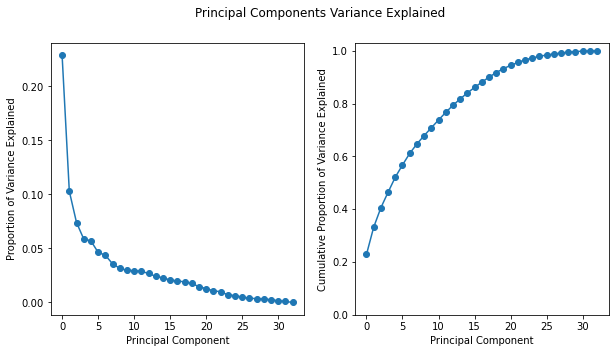

In [141]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot of proportion of variance explained
ax[0].plot(pca.explained_variance_ratio_, marker='o')
ax[0].set_xlabel('Principal Component')
ax[0].set_ylabel('Proportion of Variance Explained')

# Plot of cumulative proportion of variance explained
ax[1].plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
ax[1].set_xlabel('Principal Component')
ax[1].set_ylabel('Cumulative Proportion of Variance Explained')
ax[1].set_ylim(0, 1.03)
fig.suptitle("Principal Components Variance Explained")

### 2.2 PCA Examine the Loading Vector Values

In [142]:
pc2_df = pd.DataFrame(pca.components_[:2].T,
            index=X_scaled.columns,
            columns=['PC1', 'PC2'])

# Top 5 PC1 variables
top_5_pc1 = pc2_df.loc[pc2_df['PC1'].abs().sort_values(ascending=False).index].head(5)
# Top 5 PC2 variables 
top_5_pc2 = pc2_df.loc[pc2_df['PC2'].abs().sort_values(ascending=False).index].head(5)

print(top_5_pc1['PC1'])
print(top_5_pc2['PC2'])

NoOfOtherSpecialCharsInURL    0.315503
URLSimilarityIndex           -0.302952
URLLength                     0.288370
NoOfLettersInURL              0.280379
NoOfDegitsInURL               0.260896
Name: PC1, dtype: float64
NoOfEqualsInURL       0.340564
URLLength             0.290611
NoOfLettersInURL      0.268653
NoOfQMarkInURL        0.255383
NoOfAmpersandInURL    0.253680
Name: PC2, dtype: float64


In [143]:
# Top 10 PC1 variables
top_10_pc1 = pc2_df.loc[pc2_df['PC1'].abs().sort_values(ascending=False).index].head(10)
# Top 10 PC2 variables 
top_10_pc2 = pc2_df.loc[pc2_df['PC2'].abs().sort_values(ascending=False).index].head(10)

print(top_10_pc1['PC1'])
print(top_10_pc2['PC2'])

NoOfOtherSpecialCharsInURL    0.315503
URLSimilarityIndex           -0.302952
URLLength                     0.288370
NoOfLettersInURL              0.280379
NoOfDegitsInURL               0.260896
CharContinuationRate         -0.243091
DomainTitleMatchScore        -0.239521
SpacialCharRatioInURL         0.237412
URLTitleMatchScore           -0.230095
DegitRatioInURL               0.217864
Name: PC1, dtype: float64
NoOfEqualsInURL       0.340564
URLLength             0.290611
NoOfLettersInURL      0.268653
NoOfQMarkInURL        0.255383
NoOfAmpersandInURL    0.253680
NoOfSelfRef           0.249363
LineOfCode            0.248699
NoOfDegitsInURL       0.246804
NoOfExternalRef       0.229080
NoOfImage             0.213110
Name: PC2, dtype: float64


When looking at the top five PC1 loading vector values we see that number of special characters has the largest impact on the first principal component. You have similar correlated variables that also indicated as they increase the value of PC1 increases, and that is URL length, number of letters in the URL, and number of digits in the URL. This would seem to suggest that the most variance is seen in having websites with complex and long URLs, and then websites with simpler and shorter URLs.  This is confirmed by the URL similarity index, which reduces the value of PC1, and is used to indicate if the URL matches standard structures of known / popular website URLs.

URLs that have unusual or complex structures (longer, with more special characters and digits) might score higher on PC1, whereas more standard, predictable URLs might score lower.  So, the dataset may have URLs with long complex structurs and URLs with simple and more standard ones.

For PC2 the number of equals signs has the highest influence.  Then, URL length and special characters like question marks and ampersands also tend to increase the value for PC2.  These appear correlated, which makes sense as the URL increases and get more complex, letters and special characters could be used. You see more specific types of special characters.

When it is expanding to the top 10, then you still see more complicated URLs increase the first principal component.  In the second principal component, you see that website features, like the number of images, lines of code, and the number of references or links increase the second principal component.

### 2.3 1st and 2nd Principal Component Plot

Text(0.5, 1.0, 'First and Second Principal Component')

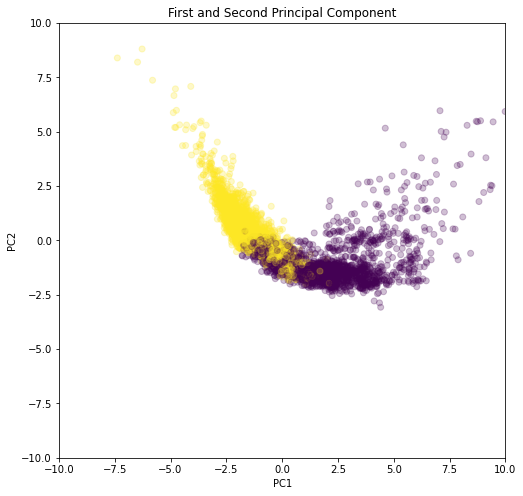

In [144]:
fig , ax = plt.subplots(1, 1, figsize=(8,8))

ax.scatter(pca_out[:,0], pca_out[:,1], alpha=0.25, c=url_sample_data['label'])

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_xlim(-10,10)
ax.set_ylim(-10,10)
ax.set_title("First and Second Principal Component")

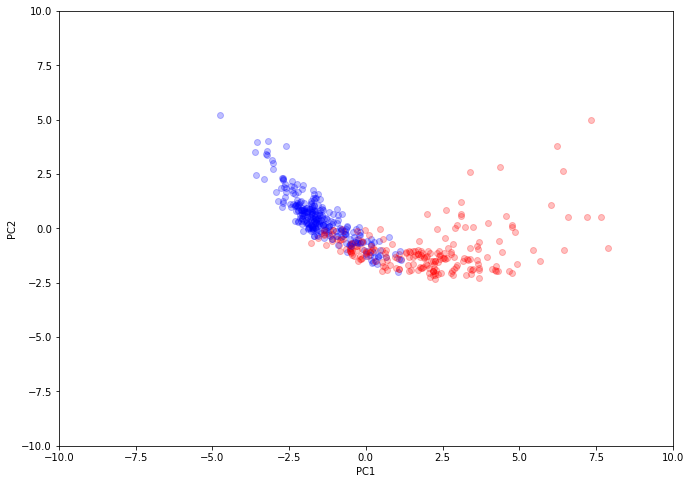

In [145]:
fig , ax1 = plt.subplots(figsize=(11,8))

ax1.set_xlim(-10,10)
ax1.set_ylim(-10,10)

# Plot states names for PC1 and PC2
for i, label in enumerate(url_sample.label.to_list()):
    if i % 10 == 0:
        # plot point
        ax1.scatter(pca_out[i,0], pca_out[i,1], c='b' if label == 1 else 'r', alpha=0.25)

ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2");

### 3.0 SVD

In [146]:
# Perform SVD
U, s, V = np.linalg.svd(X_scaled, full_matrices=False)

In [147]:
s.shape

(33,)

### 3.0.1 SVD Interpretation on U and V*

1. Since we are performing SVD on the scaled data of the original dataset, it is equivalent to performing PCA on the original dataset
2. The right singular vectors are the principal component axis.
3. The left singular vectors are the principal component scores divided by the singular values.

### 3.1 SVD Principal Components

Text(0.5, 0, 'Principal Component')

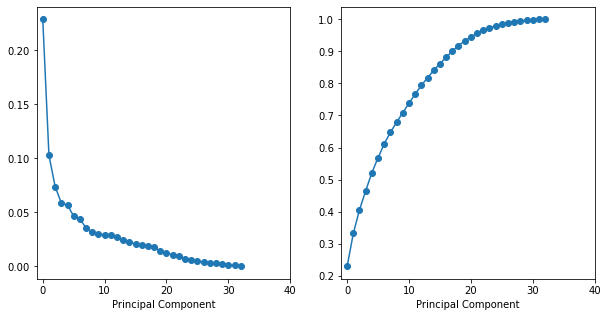

In [148]:
# Find the explained variance
explained_variance_ratio = (s ** 2) / np.sum(s ** 2)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot of singular values
ax[0].plot(explained_variance_ratio, marker='o')
ax[0].set_xlim(-1, 40)
ax[0].set_xlabel('Principal Component')
ax[1].plot(np.cumsum(explained_variance_ratio), marker='o')
ax[1].set_xlim(-1, 40)
ax[1].set_xlabel('Principal Component')

We need at 18 principal components to explain approximately 90% of the variance on our dataset.

In [149]:
U.shape

(5000, 33)

### 4.0 Kmeans

### 4.1 Kmeans 2 Clusters

#### 4.1.1 Perform Kmeans

In [150]:
kmeans = KMeans(n_clusters=2,
                random_state=2,
                n_init=20).fit(X_scaled)

Text(0.5, 0.98, 'K-means - 2 Clusters')

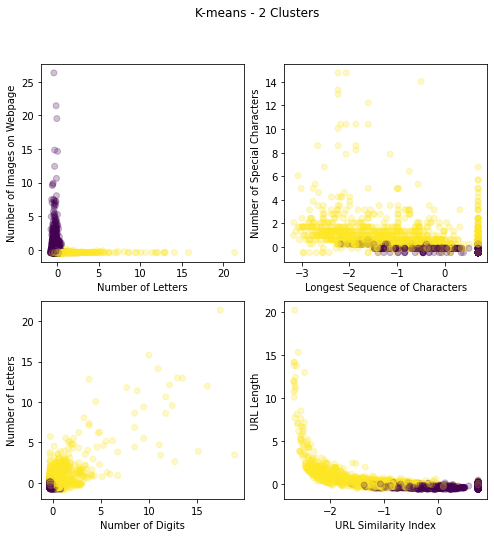

In [151]:
fig, ax = plt.subplots(2, 2, figsize=(8,8))

ax[0,0].scatter(X_scaled['NoOfLettersInURL'], X_scaled['NoOfImage'], 
              c=kmeans.labels_, alpha=0.25)
ax[0,0].set_xlabel('Number of Letters')
ax[0,0].set_ylabel('Number of Images on Webpage')

ax[0,1].scatter(X_scaled['CharContinuationRate'], X_scaled['NoOfOtherSpecialCharsInURL'], 
              c=kmeans.labels_, alpha=0.25)
ax[0,1].set_xlabel('Longest Sequence of Characters')
ax[0,1].set_ylabel('Number of Special Characters')

ax[1,0].scatter(X_scaled['NoOfDegitsInURL'], X_scaled['NoOfLettersInURL'], 
              c=kmeans.labels_, alpha=0.25)
ax[1,0].set_xlabel('Number of Digits')
ax[1,0].set_ylabel('Number of Letters')

ax[1,1].scatter(X_scaled['URLSimilarityIndex'], X_scaled['URLLength'], 
              c=kmeans.labels_, alpha=0.25)
ax[1,1].set_xlabel('URL Similarity Index')
ax[1,1].set_ylabel('URL Length')

fig.suptitle("K-means - 2 Clusters")

#### 4.1.2 Examine the 2 cluster items

In [152]:
# Get examples of URLs from the two different clusters
zero_indexes = np.where(kmeans.labels_ == 0)[0]
one_indexes = np.where(kmeans.labels_ == 1)[0]

group0_random_indexes = np.random.choice(zero_indexes, size=5, replace=False)
print(group0_random_indexes)
group1_random_indexes = np.random.choice(one_indexes, size=5, replace=False)
print(group1_random_indexes)

[3792  568  831   86 2348]
[1447 2824  981 2888 3523]


In [153]:
# First Group
X.iloc[group0_random_indexes]

,URLLength,DomainLength,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,NoOfObfuscatedChar,ObfuscationRatio,...,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef
URL,,,,,,,,,,,,,,,,,,,,,
https://www.financedirectory.net.au,34,27,100.000000,0.850000,0.010086,0.063588,2,2,0,0.0,...,0,0,0,0,19,5,11,140,1,141
http://www.enzteflon.com/jp,27,17,63.143382,1.000000,0.522907,0.055842,3,1,0,0.0,...,1,0,0,0,0,0,1,0,0,0
https://www.auspop.com.au,24,17,100.000000,0.700000,0.010086,0.063976,2,2,0,0.0,...,0,0,0,2,18,12,28,59,5,61
https://www.clevelandpolicefoundation.org,40,33,100.000000,1.000000,0.079963,0.062026,3,1,0,0.0,...,0,0,0,2,31,23,42,122,6,128
https://www.israir.co.il,23,16,100.000000,0.777778,0.001354,0.069597,2,2,0,0.0,...,1,0,0,2,10,3,44,30,101,20


In [154]:
# Second Group
X.iloc[group1_random_indexes]

,URLLength,DomainLength,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,NoOfObfuscatedChar,ObfuscationRatio,...,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef
URL,,,,,,,,,,,,,,,,,,,,,
http://arstmping002.web.app/,28,20,49.190476,0.812500,0.001502,0.041671,3,1,0,0.0,...,0,0,0,0,0,0,0,0,0,0
https://fb-restriction-case-2a201.web.app/,42,33,34.327230,0.517241,0.001502,0.050720,3,1,0,0.0,...,0,0,0,0,0,0,0,0,0,3
http://216.172.187.13/,21,14,41.777778,0.363636,0.000000,0.001569,2,2,0,0.0,...,0,0,0,0,0,0,0,0,0,0
https://ipfs.io/ipfs/bafybeicvlw6glg2eahh6m3rvfivzmcrjfazdfqzqgl6l5n2ah7fotrz3tm/aluindex.html,94,7,9.447791,1.000000,0.012927,0.037762,2,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
https://dtplkvixf.web.app/,26,17,54.191033,0.769231,0.001502,0.034421,3,1,0,0.0,...,1,0,0,0,1,0,0,0,0,1


In [155]:
# First Group, look at the extra columns
X.iloc[group0_random_indexes][['NoOfLettersInURL','LetterRatioInURL','NoOfDegitsInURL','DegitRatioInURL','NoOfEqualsInURL','NoOfQMarkInURL','NoOfAmpersandInURL','NoOfOtherSpecialCharsInURL','SpacialCharRatioInURL','LineOfCode','LargestLineLength','DomainTitleMatchScore','URLTitleMatchScore']]

,NoOfLettersInURL,LetterRatioInURL,NoOfDegitsInURL,DegitRatioInURL,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,NoOfOtherSpecialCharsInURL,SpacialCharRatioInURL,LineOfCode,LargestLineLength,DomainTitleMatchScore,URLTitleMatchScore
URL,,,,,,,,,,,,,
https://www.financedirectory.net.au,20,0.588,0,0.0,0,0,0,2,0.059,681,494,0.0,0.0
http://www.enzteflon.com/jp,14,0.519,0,0.0,0,0,0,2,0.074,35,126,0.0,100.0
https://www.auspop.com.au,10,0.417,0,0.0,0,0,0,2,0.083,1412,9381,0.0,0.0
https://www.clevelandpolicefoundation.org,27,0.675,0,0.0,0,0,0,1,0.025,2431,9381,100.0,100.0
https://www.israir.co.il,9,0.391,0,0.0,0,0,0,2,0.087,18419,6389,0.0,0.0


In [156]:
# First Group, look at the extra columns
X.iloc[group1_random_indexes][['NoOfLettersInURL','LetterRatioInURL','NoOfDegitsInURL','DegitRatioInURL','NoOfEqualsInURL','NoOfQMarkInURL','NoOfAmpersandInURL','NoOfOtherSpecialCharsInURL','SpacialCharRatioInURL','LineOfCode','LargestLineLength','DomainTitleMatchScore','URLTitleMatchScore']]

,NoOfLettersInURL,LetterRatioInURL,NoOfDegitsInURL,DegitRatioInURL,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,NoOfOtherSpecialCharsInURL,SpacialCharRatioInURL,LineOfCode,LargestLineLength,DomainTitleMatchScore,URLTitleMatchScore
URL,,,,,,,,,,,,,
http://arstmping002.web.app/,15,0.536,3,0.107,0,0,0,3,0.107,2,37,6.25,6.25
https://fb-restriction-case-2a201.web.app/,24,0.571,4,0.095,0,0,0,6,0.143,108,8125,0.00,0.00
http://216.172.187.13/,0,0.000,11,0.524,0,0,0,3,0.143,2,28,0.00,0.00
https://ipfs.io/ipfs/bafybeicvlw6glg2eahh6m3rvfivzmcrjfazdfqzqgl6l5n2ah7fotrz3tm/aluindex.html,72,0.766,9,0.096,0,0,0,5,0.053,9,102,0.00,0.00
https://dtplkvixf.web.app/,15,0.577,0,0.000,0,0,0,3,0.115,36,249,0.00,0.00


We looking at the 2 clusters, two differences stand out.  First is that URLSimilarityIndex is usually higher or 100 for almost all URLs in the first cluster.  Second, the number of JavaScript files, CSS files, images, and referrences to other web pages are much larger, or non-zero in the first cluster.  In cluster 2, the URLSimilarityIndex is lower, for the URLs we randomly selected.  Also, the number of JavaScript files, CSS files, images, and referrences to other pages is usually 0.

We can see the legitimate label for the two clusters also appears to match. The second cluster is legitimate websites and the first cluster all has the label field as 0, which means they are phishing websites.

#### 4.1.3 Compare Kmean Results to the Actual Grouping

In [157]:
def getAccuracy(cfMatrix):
    accuracy = (cfMatrix[0][0]+cfMatrix[1][1])/(cfMatrix[0][0]+cfMatrix[0][1]+cfMatrix[1][0]+cfMatrix[1][1])
    return accuracy

In [158]:
# flip the label from 0 to 1, to get the correct sign
url_sample_data['label'] = 1-url_sample_data['label']

# create confusion matrix
confusion_matrix = pd.crosstab(index=kmeans.labels_, columns=url_sample_data['label'], rownames=[''])
print(confusion_matrix)
acc = getAccuracy(confusion_matrix)
print("Kmeans 2 cluster Accuracy: {:.2f}%".format(acc*100))

label     0     1
                 
0      2851   633
1        52  1464
Kmeans 2 cluster Accuracy: 86.30%


#### 4.1.4 Kmeans on 18 Principal Components

In [159]:
# Number of principal components
r = 18

singular_vector_space = U[:,0:r] * s[0:r]

kmeans2 = KMeans(n_clusters=2,
                random_state=2,
                n_init=20).fit(singular_vector_space)

Text(0, 0.5, 'URL Length')

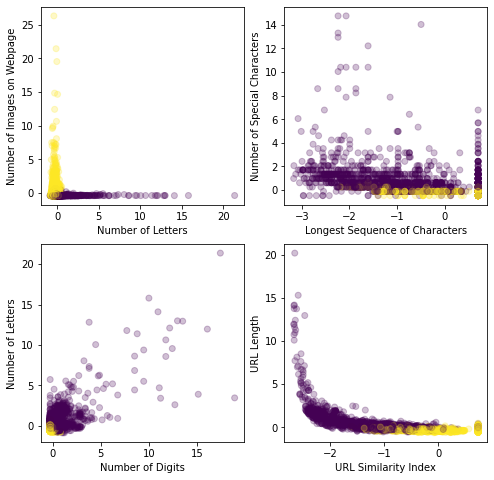

In [160]:
fig, ax = plt.subplots(2, 2, figsize=(8,8))

ax[0,0].scatter(X_scaled['NoOfLettersInURL'], X_scaled['NoOfImage'], 
              c=kmeans2.labels_, alpha=0.25)
ax[0,0].set_xlabel('Number of Letters')
ax[0,0].set_ylabel('Number of Images on Webpage')

ax[0,1].scatter(X_scaled['CharContinuationRate'], X_scaled['NoOfOtherSpecialCharsInURL'], 
              c=kmeans2.labels_, alpha=0.25)
ax[0,1].set_xlabel('Longest Sequence of Characters')
ax[0,1].set_ylabel('Number of Special Characters')

ax[1,0].scatter(X_scaled['NoOfDegitsInURL'], X_scaled['NoOfLettersInURL'], 
              c=kmeans2.labels_, alpha=0.25)
ax[1,0].set_xlabel('Number of Digits')
ax[1,0].set_ylabel('Number of Letters')

ax[1,1].scatter(X_scaled['URLSimilarityIndex'], X_scaled['URLLength'], 
              c=kmeans2.labels_, alpha=0.25)
ax[1,1].set_xlabel('URL Similarity Index')
ax[1,1].set_ylabel('URL Length')

In [162]:
# flip the label from 0 to 1, to get the correct sign
url_sample_data['label'] = 1-url_sample_data['label']

# create confusion matrix
confusion_matrix = pd.crosstab(index=kmeans2.labels_, columns=url_sample_data['label'], rownames=[''])
print(confusion_matrix)
acc = getAccuracy(confusion_matrix)
print("Kmeans 2 cluster Accuracy: {:.2f}%".format(acc*100))

label     0     1
                 
0      1463    50
1       634  2853
Kmeans 2 cluster Accuracy: 86.32%


### 4.2 Kmeans 3 clusters

#### 4.2.1 Calculate Kmeans for 3 clusters

In [163]:
kmeans3 = KMeans(n_clusters=3,
                random_state=2,
                n_init=20).fit(X_scaled)

#### 4.2.2 Plot the 3 clusters on some variables

Text(0.5, 0.98, 'K-means - 3 Clusters')

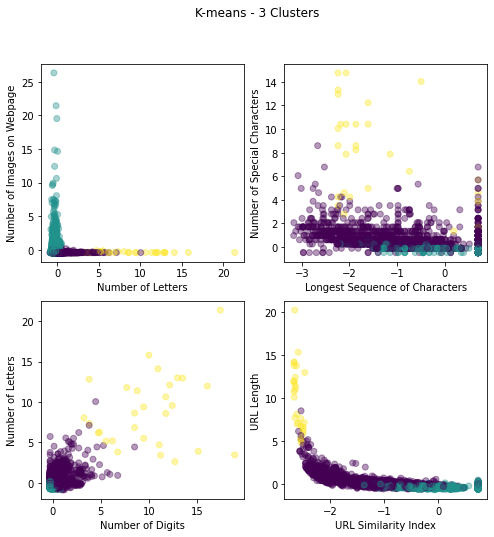

In [164]:
fig, ax = plt.subplots(2, 2, figsize=(8,8))

ax[0,0].scatter(X_scaled['NoOfLettersInURL'], X_scaled['NoOfImage'], 
              c=kmeans3.labels_, alpha=0.4)
ax[0,0].set_xlabel('Number of Letters')
ax[0,0].set_ylabel('Number of Images on Webpage')

ax[0,1].scatter(X_scaled['CharContinuationRate'], X_scaled['NoOfOtherSpecialCharsInURL'], 
              c=kmeans3.labels_, alpha=0.4)
ax[0,1].set_xlabel('Longest Sequence of Characters')
ax[0,1].set_ylabel('Number of Special Characters')

ax[1,0].scatter(X_scaled['NoOfDegitsInURL'], X_scaled['NoOfLettersInURL'], 
              c=kmeans3.labels_, alpha=0.4)
ax[1,0].set_xlabel('Number of Digits')
ax[1,0].set_ylabel('Number of Letters')

ax[1,1].scatter(X_scaled['URLSimilarityIndex'], X_scaled['URLLength'], 
              c=kmeans3.labels_, alpha=0.4)
ax[1,1].set_xlabel('URL Similarity Index')
ax[1,1].set_ylabel('URL Length')
fig.suptitle("K-means - 3 Clusters")

#### 4.2.3 Examine differences between the 3 groups

In [165]:
# Get examples of URLs from the three different clusters
zero_indexes = np.where(kmeans3.labels_ == 0)[0]
one_indexes = np.where(kmeans3.labels_ == 1)[0]
two_indexes = np.where(kmeans3.labels_ == 2)[0]

group0_random_indexes = np.random.choice(zero_indexes, size=5, replace=False)
print(group0_random_indexes)
group1_random_indexes = np.random.choice(one_indexes, size=5, replace=False)
print(group1_random_indexes)
group2_random_indexes = np.random.choice(two_indexes, size=5, replace=False)
print(group2_random_indexes)

[2853 3867 2139 1632 2798]
[4797 3486 4427 1800  693]
[3470 1612 3896  699 3879]


In [166]:
# First Group
X.iloc[group0_random_indexes]

,URLLength,DomainLength,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,NoOfObfuscatedChar,ObfuscationRatio,...,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef
URL,,,,,,,,,,,,,,,,,,,,,
http://www.lvluo.nowurl.fun,26,20,44.898897,0.583333,0.000119,0.045017,3,2,0,0.0,...,0,0,0,0,0,0,0,0,0,0
https://att-105146.weeblysite.com/,33,25,66.695385,0.809524,0.522907,0.044085,3,1,0,0.0,...,1,0,0,0,0,0,0,0,0,1
https://bafybeihckkjsi6zfs6jwbqenmfl2qph72ihyfbj3vxie7mjhfz24mlrbsi.ipfs.dweb.link/mufife.html,94,74,9.467062,0.246377,0.000331,0.033178,4,2,0,0.0,...,0,0,0,0,0,0,0,0,0,0
https://454e4c09-25c9-42d3-a4f5-f4d6b0816cc4.id.repl.co,55,47,32.766347,0.204545,0.005977,0.027171,2,2,0,0.0,...,0,0,0,0,0,0,0,0,0,2
https://webmail-108950.weeblysite.com/,38,29,55.299247,0.680000,0.522907,0.044229,3,1,0,0.0,...,0,0,0,0,19,3,9,1,0,4


In [167]:
# Second Group
X.iloc[group1_random_indexes]

,URLLength,DomainLength,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,NoOfObfuscatedChar,ObfuscationRatio,...,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef
URL,,,,,,,,,,,,,,,,,,,,,
http://www.koliast.com,21,15,83.471074,1.0,0.522907,0.065769,3,1,0,0.0,...,0,0,0,0,0,0,0,0,0,0
https://www.nationalgalleries.org,32,25,100.000000,1.0,0.079963,0.066414,3,1,0,0.0,...,0,0,0,2,77,3,13,218,0,34
https://www.twocatswitchery.com,30,23,100.000000,1.0,0.522907,0.058802,3,1,0,0.0,...,0,0,0,0,28,4,3,35,0,35
https://www.rauma.fi,19,12,100.000000,1.0,0.002760,0.055580,2,1,0,0.0,...,0,0,0,0,18,3,14,371,1,420
https://www.kcur.org,19,12,100.000000,1.0,0.079963,0.057876,3,1,0,0.0,...,0,0,0,3,127,1,6,276,0,321


In [168]:
# Third Group
X.iloc[group2_random_indexes]

,URLLength,DomainLength,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,NoOfObfuscatedChar,ObfuscationRatio,...,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef
URL,,,,,,,,,,,,,,,,,,,,,
https://allianceinstrumentation.com.sg/spp/24mmkt23xc4ob9fplihf0t2k.php?75f44c1676278209d579478135516f650042b32de786fdd9d579478135516f650042b32de786fdd9d579478135516f650042b32de786fdd9d579478135516f650042b32de786fdd9d579478135516f650042b32de786fdd9=&email=,256,30,7.309780,0.888889,0.000895,0.018960,2,1,0,0.0,...,0,0,0,0,0,0,0,0,0,0
http://creditrepairr.com/wp-includes/js/jcrop/cgi/bofa/validation/login.php?cmd=login_submit&amp;id=cb5af7827d1ee6c0235a9653cdd9fd14cb5af7827d1ee6c0235a9653cdd9fd14&amp;session=cb5af7827d1ee6c0235a9653cdd9fd14cb5af7827d1ee6c0235a9653cdd9fd14,241,17,6.461221,1.000000,0.522907,0.036496,3,0,0,0.0,...,0,0,0,0,19,4,1,0,5,0
https://creditrepairr.com/wp-includes/js/jcrop/cgi/bofa/validation/login.php?cmd=login_submit&id=1d496e8ddf04b111b180b9c949ac97651d496e8ddf04b111b180b9c949ac9765&session=1d496e8ddf04b111b180b9c949ac97651d496e8ddf04b111b180b9c949ac9765,234,17,6.691661,1.000000,0.522907,0.031392,3,0,0,0.0,...,0,0,0,0,19,4,1,0,5,0
http://www.kueronakayaeotn.co.jp.kuerocekayaoato.ppjltg.top/ai/?authenticated=true&amp;amp;amp;amp;amp;openid/gp/signin/x&amp;amp;amp;amp;i=a&amp;amp;amp;amp;oauth=m&amp;amp;amp;amp;i?ie=utf8&amp;amp;amp;amp;ref_=rhf_custrec_signind6549a16667b4d8f54f58ce469d61277c83d5263,271,52,5.422499,0.363636,0.000275,0.047603,3,5,0,0.0,...,0,0,0,0,10,2,1,0,0,0
https://attitude.mx/bbmps/login.html?cmd=login_submit&id=710293544ef81e34985ce64b41820d6d710293544ef81e34985ce64b41820d6d&session=710293544ef81e34985ce64b41820d6d710293544ef81e34985ce64b41820d6d,193,11,5.429703,1.000000,0.001722,0.024900,2,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [169]:
# Cluster sizes
print(len(zero_indexes))
print(len(one_indexes))
print(len(two_indexes))

1555
3416
29


### 4.3 Kmeans 5 Cluster

#### 4.3.1 Perform Kmeans with 5 clusters

In [170]:
kmeans5 = KMeans(n_clusters=5,
                random_state=2,
                n_init=20).fit(X_scaled)

#### 4.3.2 Graph the 5 clusters on variables

Text(0.5, 0.98, 'K-means - 5 Clusters')

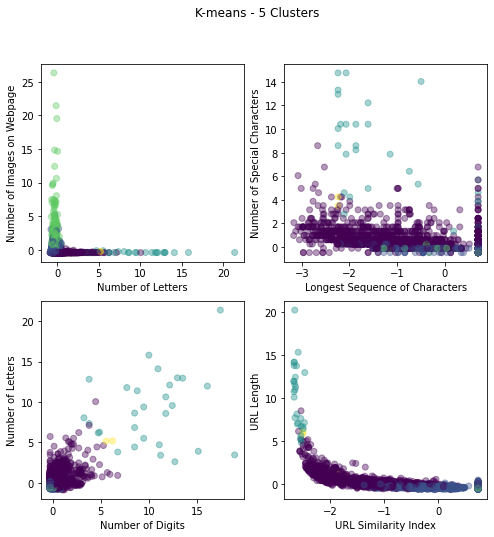

In [175]:
fig, ax = plt.subplots(2, 2, figsize=(8,8))

ax[0,0].scatter(X_scaled['NoOfLettersInURL'], X_scaled['NoOfImage'], 
              c=kmeans5.labels_, alpha=0.4)
ax[0,0].set_xlabel('Number of Letters')
ax[0,0].set_ylabel('Number of Images on Webpage')

ax[0,1].scatter(X_scaled['CharContinuationRate'], X_scaled['NoOfOtherSpecialCharsInURL'], 
              c=kmeans5.labels_, alpha=0.4)
ax[0,1].set_xlabel('Longest Sequence of Characters')
ax[0,1].set_ylabel('Number of Special Characters')

ax[1,0].scatter(X_scaled['NoOfDegitsInURL'], X_scaled['NoOfLettersInURL'], 
              c=kmeans5.labels_, alpha=0.4)
ax[1,0].set_xlabel('Number of Digits')
ax[1,0].set_ylabel('Number of Letters')

ax[1,1].scatter(X_scaled['URLSimilarityIndex'], X_scaled['URLLength'], 
              c=kmeans5.labels_, alpha=0.4)
ax[1,1].set_xlabel('URL Similarity Index')
ax[1,1].set_ylabel('URL Length')
fig.suptitle("K-means - 5 Clusters")

In [58]:
# Get examples of URLs from the three different clusters
zero_indexes = np.where(kmeans5.labels_ == 0)[0]
one_indexes = np.where(kmeans5.labels_ == 1)[0]
two_indexes = np.where(kmeans5.labels_ == 2)[0]
three_indexes = np.where(kmeans5.labels_ == 3)[0]
four_indexes = np.where(kmeans5.labels_ == 4)[0]

group0_random_indexes = np.random.choice(zero_indexes, size=5, replace=False)
print(group0_random_indexes)
group1_random_indexes = np.random.choice(one_indexes, size=5, replace=False)
print(group1_random_indexes)
group2_random_indexes = np.random.choice(two_indexes, size=5, replace=False)
print(group2_random_indexes)
group3_random_indexes = np.random.choice(three_indexes, size=5, replace=False)
print(group3_random_indexes)
group4_random_indexes = np.random.choice(four_indexes, size=5, replace=False)
print(group4_random_indexes)

[4882 2886 4753 4126 2591]
[1282 1649 4060 3309 4733]
[ 917 3896 1605  634 1612]
[1468 2303  553  867 3487]
[2377 2166 2458  789 2708]


In [57]:
# Cluster sizes
print(len(zero_indexes))
print(len(one_indexes))
print(len(two_indexes))
print(len(three_indexes))
print(len(four_indexes))

1508
3075
28
383
6


In [59]:
# First Group
X.iloc[group0_random_indexes]

,URLLength,DomainLength,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,NoOfObfuscatedChar,ObfuscationRatio,...,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef
URL,,,,,,,,,,,,,,,,,,,,,
https://resgate-desco-online.co.ua/html/classico/index.shtm/,60,26,33.572886,0.347826,0.002324,0.062438,2,1,0,0.0,...,0,0,0,0,38,1,4,4,4,0
https://ms-sharedfile-nd.firebaseapp.com/,40,32,56.592665,0.428571,0.522907,0.057350,3,1,0,0.0,...,0,0,0,0,1,1,1,1,0,0
https://www.1lnch.me/index.html,30,12,44.099723,1.000000,0.003638,0.049030,2,1,0,0.0,...,0,0,0,0,0,0,0,0,0,0
https://business-confirm-appeal-31539.web.app/,46,37,41.663143,0.424242,0.001502,0.046018,3,1,0,0.0,...,0,0,0,0,0,0,0,0,0,3
http://aybitufokq.duckdns.org/,30,22,62.163133,0.611111,0.079963,0.044480,3,1,0,0.0,...,0,0,0,0,14,1,0,0,0,0


In [60]:
# Second Group
X.iloc[group1_random_indexes]

,URLLength,DomainLength,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,NoOfObfuscatedChar,ObfuscationRatio,...,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef
URL,,,,,,,,,,,,,,,,,,,,,
https://www.christianmonotheism.com,34,27,100.000000,1.000000,0.522907,0.065876,3,1,0,0.0,...,0,0,0,2,4,4,10,11,0,8
https://www.harvardarabalumni.org,32,25,100.000000,1.000000,0.079963,0.058074,3,1,0,0.0,...,0,0,0,0,14,14,43,2,0,14
http://www.balsagarelectrical.com,33,26,67.157743,1.000000,0.522907,0.065028,3,1,0,0.0,...,0,0,0,0,0,0,0,0,0,0
https://www.edepro.com,21,14,100.000000,1.000000,0.522907,0.071736,3,1,0,0.0,...,0,0,0,0,40,2,8,133,12,9
https://www.espace-ethique.org,29,22,100.000000,0.571429,0.079963,0.062208,3,1,0,0.0,...,0,0,0,2,144,12,23,111,0,82


In [61]:
# Third Group
X.iloc[group2_random_indexes]

,URLLength,DomainLength,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,NoOfObfuscatedChar,ObfuscationRatio,...,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef
URL,,,,,,,,,,,,,,,,,,,,,
http://129.226.211.41/v3/signin/identifier?dsh=s-569711281%3a1679331642386214&amp%3bcontinue=https%3a%2f%2faccounts.google.com%2f%3f&amp%3bfollowup=https%3a%2f%2faccounts.google.com%2f%3f&amp%3bxrealip=107.178.232.255&ifkv=awnoghe1inrxwhvpi334sk3y86icuhhfmpxvrflpokgb2oiy90yshmzm8osxxc4_o19uznsfbfsvxa&passive=1209600&xrealip=34.198.46.118&flowname=weblitesignin&flowentry=servicelogin,385,14,2.657978,0.363636,0.000000,0.036241,2,2,0,0.0,...,1,0,0,2,1,0,0,2,0,5
https://creditrepairr.com/wp-includes/js/jcrop/cgi/bofa/validation/login.php?cmd=login_submit&id=1d496e8ddf04b111b180b9c949ac97651d496e8ddf04b111b180b9c949ac9765&session=1d496e8ddf04b111b180b9c949ac97651d496e8ddf04b111b180b9c949ac9765,234,17,6.691661,1.000000,0.522907,0.031392,3,0,0,0.0,...,0,0,0,0,19,4,1,0,5,0
https://secured1-chaase.duckdns.org/chase/ce6d95183b720a5572bf09620883341e/index1.php?cmd=login_submit&id=67b49143c74ba3f4e1021957cef1a36467b49143c74ba3f4e1021957cef1a364&session=67b49143c74ba3f4e1021957cef1a36467b49143c74ba3f4e1021957cef1a364,243,27,5.573685,0.391304,0.079963,0.027492,3,1,0,0.0,...,0,0,0,0,0,0,0,0,0,0
https://3vlocksmith.com/mpsitnew/login.html?cmd=login_submit&id=1b9ea24e7975d3f2d897f1041b86f74a1b9ea24e7975d3f2d897f1041b86f74a&session=1b9ea24e7975d3f2d897f1041b86f74a1b9ea24e7975d3f2d897f1041b86f74a,200,15,5.230612,1.000000,0.522907,0.027185,3,0,0,0.0,...,0,0,0,0,2,1,0,0,1,0
http://creditrepairr.com/wp-includes/js/jcrop/cgi/bofa/validation/login.php?cmd=login_submit&amp;id=cb5af7827d1ee6c0235a9653cdd9fd14cb5af7827d1ee6c0235a9653cdd9fd14&amp;session=cb5af7827d1ee6c0235a9653cdd9fd14cb5af7827d1ee6c0235a9653cdd9fd14,241,17,6.461221,1.000000,0.522907,0.036496,3,0,0,0.0,...,0,0,0,0,19,4,1,0,5,0


In [62]:
# Fourth Group
X.iloc[group3_random_indexes]

,URLLength,DomainLength,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,NoOfObfuscatedChar,ObfuscationRatio,...,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef
URL,,,,,,,,,,,,,,,,,,,,,
https://www.villageshoeinn.net,29,22,100.0,1.0,0.038420,0.059761,3,1,0,0.0,...,0,0,0,19,225,3,24,332,3,13
https://www.uslecce.it,21,14,100.0,1.0,0.012178,0.064796,2,1,0,0.0,...,0,0,0,23,170,8,16,264,38,206
https://www.michianachryslerdodgejeepram.com,43,36,100.0,1.0,0.522907,0.059959,3,1,0,0.0,...,1,0,0,16,72,34,74,232,32,21
https://www.doorsforbuilders.com,31,24,100.0,1.0,0.522907,0.061406,3,1,0,0.0,...,0,0,1,0,126,19,10,310,3,65
https://www.geartalk.net,23,16,100.0,1.0,0.038420,0.060396,3,1,0,0.0,...,1,0,0,21,31,12,8,106,1,118


In [63]:
# Fifth Group
X.iloc[group4_random_indexes]

,URLLength,DomainLength,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,NoOfObfuscatedChar,ObfuscationRatio,...,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef
URL,,,,,,,,,,,,,,,,,,,,,
http://www.kueronekayacotn-co-jp.kuerocekayacoto.crvqvq.top/ai/?authenticated=true&amp;openid%2fgp%2fsignin%2fx%26i%3da%26oauth%3dm%26i%3fie%3dutf8%26ref_%3drhf_custrec_signin2d877722bde3d23ba3fb5d52578a3d6e99737e97,215,52,6.428977,0.363636,0.000275,0.040355,3,3,12,0.056,...,0,0,0,0,10,2,1,0,0,0
http://www.saudispine.org/one%20drive%20/login/,46,18,32.444444,1.000000,0.079963,0.051781,3,1,6,0.130,...,1,0,0,0,19,2,10,0,0,2
http://www.citizensonlinedns.dynamic-dns.net/citizens%20page/,60,37,29.387755,0.620690,0.038420,0.055338,3,2,3,0.050,...,0,0,0,0,0,0,0,0,0,0
http://mnavales.cl/.well-known/sign%20in/index.html,50,11,25.162994,1.000000,0.001219,0.049762,2,0,3,0.060,...,0,0,0,0,2,0,0,0,0,0
http://starzmarketings.com/wp-includes/royal%20credit%20union/index.html,71,19,25.156177,1.000000,0.522907,0.052262,3,0,6,0.085,...,0,0,0,0,0,0,0,1,0,1


### 5.0 Hierarchical Clustering


In [64]:
# There are too many records for these scripts to run in a reasonable amount of time
# So, we take a random sample of 60 records
url_sample = phishingurl_data.sample(60, random_state=13)

# Set index equal to the domain field
url_sample.set_index('Domain', inplace=True)

# Drop text fields: Filename, URL, TLD, Title
url_sample_data = url_sample.drop(['FILENAME', 'URL', 'TLD', 'Title'],axis = 1)

In [65]:
# Drop true / false values
X = url_sample_data.drop(['HasObfuscation', 
                          'IsHTTPS',
                          'IsDomainIP', 
                          'HasTitle',
                          'HasFavicon', 
                          'Robots',
                          'IsResponsive',
                          'HasDescription',
                          'HasExternalFormSubmit', 
                          'HasSocialNet', 
                          'HasSubmitButton', 
                          'HasHiddenFields', 
                          'HasPasswordField', 
                          'Bank',
                          'Pay',
                          'Crypto',
                          'HasCopyrightInfo',
                          'label'],axis = 1)

# Scale the dataset
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X),columns=X.columns,index=X.index)

### 5.1 Hierarchical  clustering 2 Clusters

### 5.1.1 Complete linkage clustering

In [66]:
HClust = AgglomerativeClustering
hc_comp = HClust(distance_threshold=0,
                 n_clusters=None,
                 linkage='complete')
hc_comp.fit(X_scaled)


AgglomerativeClustering(distance_threshold=0, linkage='complete',
                        n_clusters=None)

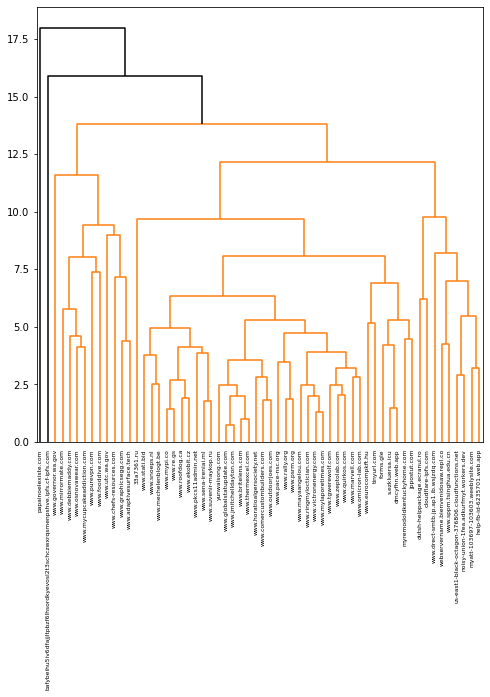

In [67]:
cargs = {'color_threshold':-np.inf,
         'above_threshold_color':'black'}
linkage_comp = compute_linkage(hc_comp)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_comp,
           ax=ax,
           color_threshold=15,
           above_threshold_color='black',labels=X.index.tolist());


### 5.1.2 Average linkage clustering

In [68]:
hc_avg = HClust(distance_threshold=0,
                n_clusters=None,
                linkage='average');
hc_avg.fit(X_scaled)

AgglomerativeClustering(distance_threshold=0, linkage='average',
                        n_clusters=None)

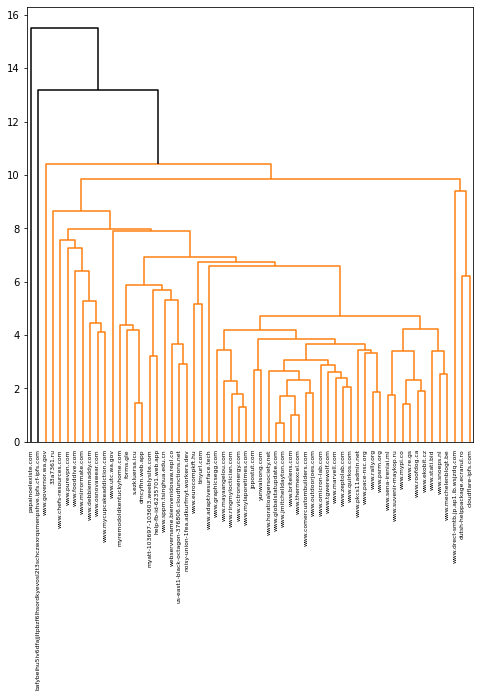

In [69]:
cargs = {'color_threshold':-np.inf,
         'above_threshold_color':'black'}
linkage_comp = compute_linkage(hc_avg)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_comp,
           ax=ax,
           color_threshold=12,
           above_threshold_color='black',labels=X.index.tolist());


### 5.1.3 Single linkage clustering

In [70]:
hc_sing = HClust(distance_threshold=0,
                 n_clusters=None,
                 linkage='single');
hc_sing.fit(X_scaled);


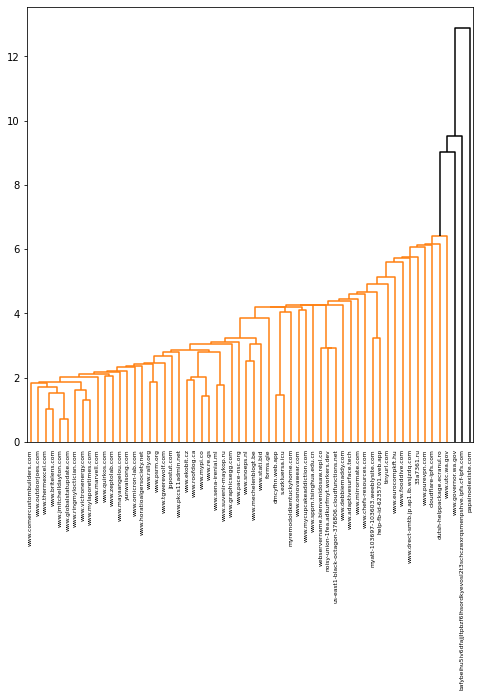

In [71]:
cargs = {'color_threshold':-np.inf,
         'above_threshold_color':'black'}
linkage_comp = compute_linkage(hc_sing)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_comp,
           ax=ax,
           color_threshold=8,
           above_threshold_color='black',labels=X.index.tolist());


### 5.1.4 Ward linkage clustering

In [72]:
hc_ward = HClust(distance_threshold=0,
                 n_clusters=None,
                 linkage='ward');
hc_ward.fit(X_scaled);

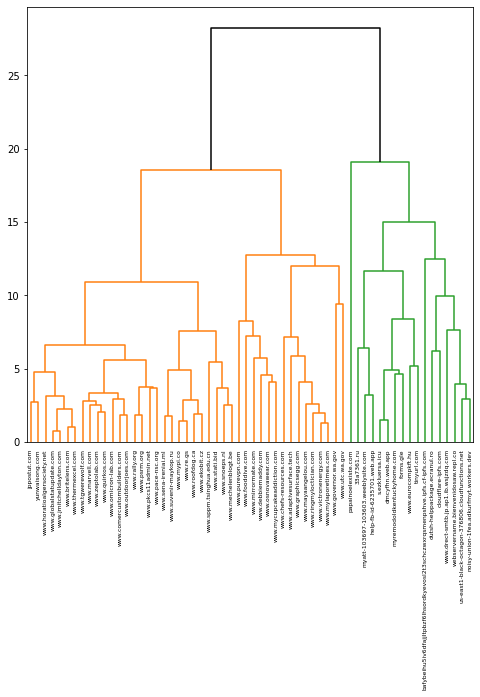

In [73]:
cargs = {'color_threshold':-np.inf,
         'above_threshold_color':'black'}
linkage_comp = compute_linkage(hc_ward)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_comp,
           ax=ax,
           color_threshold=20,
           above_threshold_color='black',labels=X.index.tolist());


In [75]:
hc_ward = HClust(distance_threshold=0,
                 n_clusters=None,
                 linkage='ward');
hc_ward.fit(X_scaled);

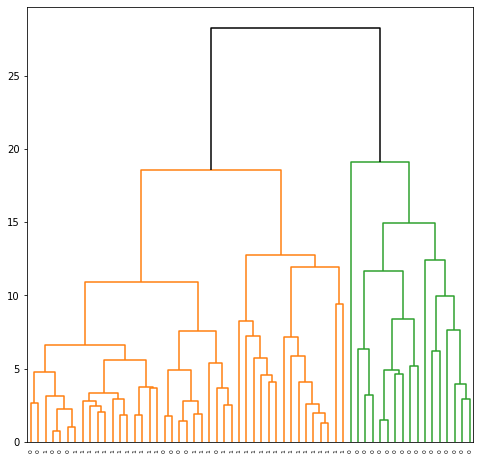

In [76]:
cargs = {'color_threshold':-np.inf,
         'above_threshold_color':'black'}
linkage_comp = compute_linkage(hc_ward)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_comp,
           ax=ax,
           color_threshold=20,
           above_threshold_color='black',labels=url_sample_data.label.tolist());


In [77]:
clusters_hc = cut_tree(linkage_comp, n_clusters=2).flatten()

In [78]:
# Get examples of URLs from the two different clusters
zero_indexes = np.where(clusters_hc == 0)[0]
one_indexes = np.where(clusters_hc == 1)[0]

group0_random_indexes = np.random.choice(zero_indexes, size=5, replace=False)
group1_random_indexes = np.random.choice(one_indexes, size=5, replace=False)


In [79]:
# First Group
X.iloc[group0_random_indexes]

,URLLength,DomainLength,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,NoOfObfuscatedChar,ObfuscationRatio,...,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef
Domain,,,,,,,,,,,,,,,,,,,,,
www.mycupcakeaddiction.com,33,26,100.0,1.000000,0.522907,0.059811,3,1,0,0.0,...,1,0,0,19,15,8,23,14,6,28
www.ringmyloctician.com,30,23,100.0,1.000000,0.522907,0.063136,3,1,0,0.0,...,0,0,0,0,31,10,14,46,0,54
www.pkcs11admin.net,26,19,100.0,0.636364,0.038420,0.047327,3,1,0,0.0,...,0,0,0,0,1,4,7,1,0,6
www.fooddive.com,23,16,100.0,1.000000,0.522907,0.061877,3,1,0,0.0,...,0,0,0,6,161,3,35,153,1,29
www.chefs-resources.com,30,23,100.0,0.666667,0.522907,0.065836,3,1,0,0.0,...,0,0,0,3,18,14,32,152,16,143


In [80]:
# Second Group
X.iloc[group1_random_indexes]

,URLLength,DomainLength,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,NoOfObfuscatedChar,ObfuscationRatio,...,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef
Domain,,,,,,,,,,,,,,,,,,,,,
myatt-103697-103603.weeblysite.com,43,34,31.982205,0.566667,0.522907,0.035070,3,1,0,0.0,...,0,0,0,0,0,0,0,0,0,1
bafybeihu5iv6dfajjltpbzf6lhsordkyevosl2t3schczwxrqsmenpshve.ipfs.cf-ipfs.com,94,76,9.412979,0.277778,0.522907,0.040401,3,2,0,0.0,...,0,0,0,0,0,0,0,0,0,0
www.drect-smtb.jp.ap1.ib.wsjzdq.com,67,35,18.479339,0.296296,0.522907,0.044917,3,5,0,0.0,...,0,0,0,0,0,0,0,0,0,0
www.eurocompkft.hu,24,18,72.789116,1.000000,0.002217,0.054784,2,1,0,0.0,...,1,1,0,0,0,0,1,0,0,0
help-fb-id-6235701.web.app,35,26,37.869822,0.545455,0.001502,0.027435,3,1,0,0.0,...,0,0,0,0,0,1,1,1,0,1


### 5.2 Hierarchical  clustering 3 Clusters

In [81]:
hc_ward = HClust(distance_threshold=0,
                 n_clusters=None,
                 linkage='ward');
hc_ward.fit(X_scaled);

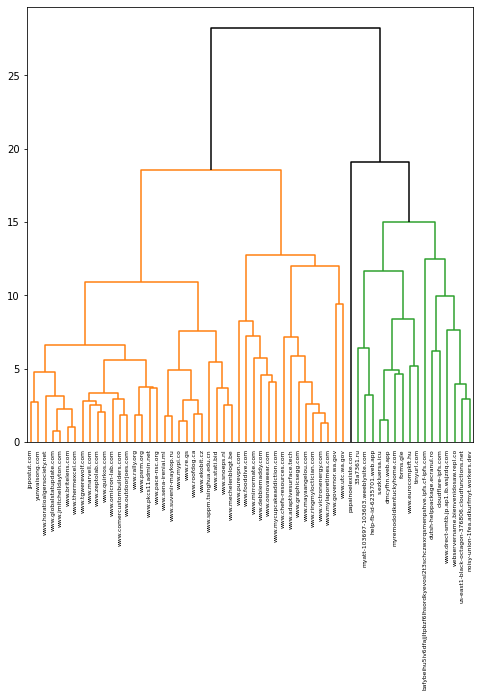

In [82]:
cargs = {'color_threshold':-np.inf,
         'above_threshold_color':'black'}
linkage_comp = compute_linkage(hc_ward)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_comp,
           ax=ax,
           color_threshold=19,
           above_threshold_color='black',labels=X.index.tolist());


In [83]:
hc_ward = HClust(distance_threshold=0,
                 n_clusters=None,
                 linkage='ward');
hc_ward.fit(X_scaled);

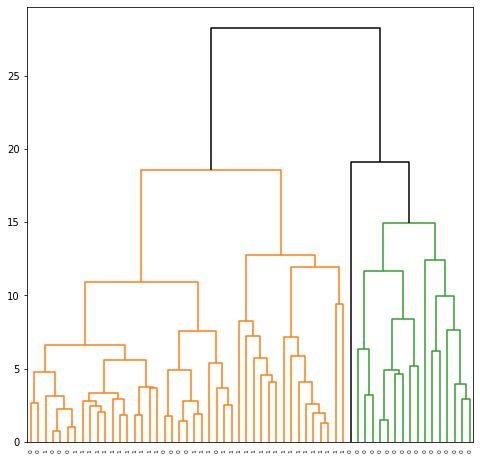

In [84]:
cargs = {'color_threshold':-np.inf,
         'above_threshold_color':'black'}
linkage_comp = compute_linkage(hc_ward)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_comp,
           ax=ax,
           color_threshold=19,
           above_threshold_color='black',labels=url_sample_data.label.tolist());


In [85]:
clusters_hc = cut_tree(linkage_comp, n_clusters=3).flatten()
clusters_hc

array([0, 0, 0, 0, 1, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2,
       0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2])

In [86]:
np.where(clusters_hc == 1)[0]

array([4], dtype=int64)

In [87]:
# Get examples of URLs from the two different clusters
zero_indexes = np.where(clusters_hc == 0)[0]
one_indexes = np.where(clusters_hc == 1)[0]
two_indexes = np.where(clusters_hc == 2)[0]
group0_random_indexes = np.random.choice(zero_indexes, size=5, replace=False)
group1_random_indexes = np.random.choice(one_indexes, size=1, replace=False)
group2_random_indexes = np.random.choice(two_indexes, size=5, replace=False)

In [88]:
# First Group
X.iloc[group0_random_indexes]

,URLLength,DomainLength,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,NoOfObfuscatedChar,ObfuscationRatio,...,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef
Domain,,,,,,,,,,,,,,,,,,,,,
www.stati.bid,19,13,79.166667,1.000000,0.000014,0.056657,3,1,0,0.0,...,0,0,0,0,0,0,0,0,0,0
www.mypi.co,17,11,85.714286,1.000000,0.005977,0.047270,2,1,0,0.0,...,0,0,0,0,1,1,2,0,0,5
www.utc.wa.gov,21,14,100.000000,0.666667,0.003328,0.054683,3,2,0,0.0,...,0,0,0,2,17,5,9,507,5,25
www.omicron-lab.com,26,19,100.000000,0.727273,0.522907,0.070389,3,1,0,0.0,...,0,0,0,0,13,8,23,90,2,14
www.ekobit.cz,20,13,100.000000,1.000000,0.003631,0.060266,2,1,0,0.0,...,0,0,0,2,41,2,14,23,2,17


In [89]:
# Second Group
X.iloc[group1_random_indexes]

,URLLength,DomainLength,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,NoOfObfuscatedChar,ObfuscationRatio,...,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef
Domain,,,,,,,,,,,,,,,,,,,,,
papainoelexiste.com,87,19,15.266204,1.0,0.522907,0.03075,3,0,0,0.0,...,0,0,0,0,1,1,0,1,0,1


In [90]:
X.iloc[group2_random_indexes]

,URLLength,DomainLength,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,NoOfObfuscatedChar,ObfuscationRatio,...,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef
Domain,,,,,,,,,,,,,,,,,,,,,
s.ezkluersa.icu,29,15,33.057851,0.909091,0.000040,0.045704,3,1,0,0.0,...,1,0,0,0,0,0,1,0,0,0
dutsh-helppackage.ecranul.ro,76,28,15.013038,0.480000,0.001523,0.040328,2,1,0,0.0,...,1,1,0,0,0,0,0,1,0,1
us-east1-black-octagon-376806.cloudfunctions.net,64,48,43.487603,0.477273,0.038420,0.051228,3,1,0,0.0,...,0,0,0,0,0,0,0,0,0,0
tinyurl.com,41,11,40.236590,1.000000,0.522907,0.060734,3,0,0,0.0,...,1,1,0,0,0,0,0,1,0,1
33a7361.ru,24,10,38.786765,0.714286,0.018013,0.017637,2,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0


### 5.3 Hierarchical  clustering 5 Clusters

In [91]:
hc_ward = HClust(distance_threshold=0,
                 n_clusters=None,
                 linkage='ward');
hc_ward.fit(X_scaled);

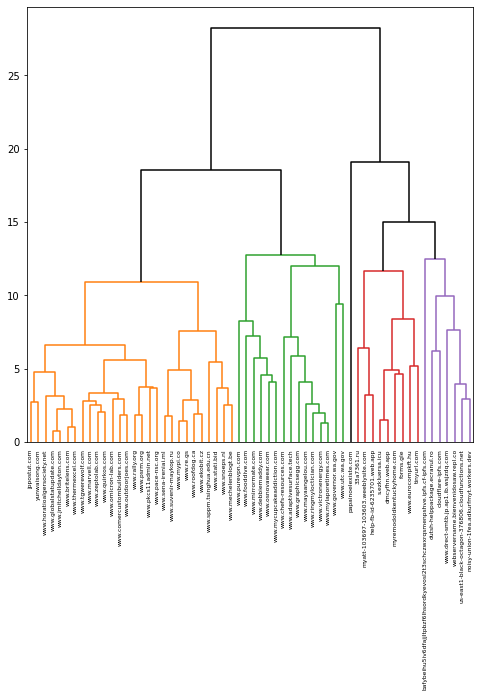

In [92]:
cargs = {'color_threshold':-np.inf,
         'above_threshold_color':'black'}
linkage_comp = compute_linkage(hc_ward)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_comp,
           ax=ax,
           color_threshold=14,
           above_threshold_color='black',labels=X.index.tolist());


In [93]:
hc_ward = HClust(distance_threshold=0,
                 n_clusters=None,
                 linkage='ward');
hc_ward.fit(X_scaled);

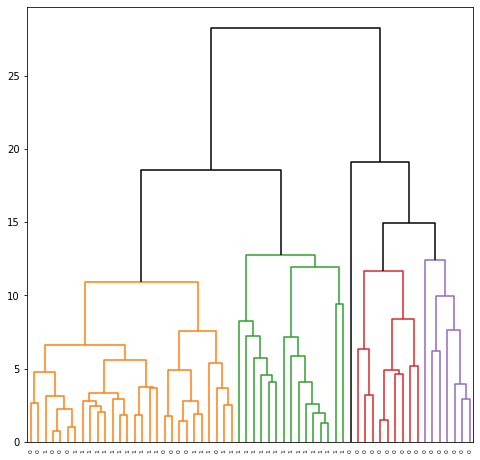

In [94]:
cargs = {'color_threshold':-np.inf,
         'above_threshold_color':'black'}
linkage_comp = compute_linkage(hc_ward)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_comp,
           ax=ax,
           color_threshold=14,
           above_threshold_color='black',labels=url_sample_data.label.tolist());


In [95]:
clusters_hc = cut_tree(linkage_comp, n_clusters=5).flatten()

In [96]:
clusters_hc

array([0, 0, 0, 0, 1, 2, 3, 0, 2, 4, 0, 0, 4, 2, 4, 0, 0, 4, 0, 0, 4, 0,
       4, 0, 0, 4, 3, 4, 0, 0, 0, 0, 2, 2, 4, 0, 0, 2, 4, 2, 0, 4, 3, 3,
       4, 3, 0, 0, 4, 0, 4, 0, 3, 0, 4, 0, 2, 0, 3, 2])

In [97]:
# Get examples of URLs from the two different clusters
zero_indexes = np.where(clusters_hc == 0)[0]
one_indexes = np.where(clusters_hc == 1)[0]
two_indexes = np.where(clusters_hc == 2)[0]
three_indexes = np.where(clusters_hc == 3)[0]
four_indexes = np.where(clusters_hc == 4)[0]

group0_random_indexes = np.random.choice(zero_indexes, size=5, replace=False)
group1_random_indexes = np.random.choice(one_indexes, size=1, replace=False)
group2_random_indexes = np.random.choice(two_indexes, size=5, replace=False)
group3_random_indexes = np.random.choice(three_indexes, size=5, replace=False)
group4_random_indexes = np.random.choice(four_indexes, size=5, replace=False)


In [98]:
# First Group
X.iloc[group0_random_indexes]

,URLLength,DomainLength,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,NoOfObfuscatedChar,ObfuscationRatio,...,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef
Domain,,,,,,,,,,,,,,,,,,,,,
www.stati.bid,19,13,79.166667,1.000000,0.000014,0.056657,3,1,0,0.0,...,0,0,0,0,0,0,0,0,0,0
www.mechelenblogt.be,27,20,100.000000,1.000000,0.003319,0.057259,2,1,0,0.0,...,0,0,0,0,14,11,6,117,0,5
www.roofdog.ca,21,14,100.000000,1.000000,0.010183,0.064404,2,1,0,0.0,...,0,0,0,0,10,1,2,3,0,35
www.sena-ireniai.ml,25,19,55.000000,0.666667,0.000131,0.068878,2,1,0,0.0,...,0,0,0,0,0,0,0,0,0,0
www.comercustombuilders.com,34,27,100.000000,1.000000,0.522907,0.063880,3,1,0,0.0,...,0,0,0,3,23,4,16,18,0,13


In [99]:
# Second Group
X.iloc[group1_random_indexes]

,URLLength,DomainLength,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,NoOfObfuscatedChar,ObfuscationRatio,...,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef
Domain,,,,,,,,,,,,,,,,,,,,,
papainoelexiste.com,87,19,15.266204,1.0,0.522907,0.03075,3,0,0,0.0,...,0,0,0,0,1,1,0,1,0,1


In [100]:
X.iloc[group2_random_indexes]

,URLLength,DomainLength,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,NoOfObfuscatedChar,ObfuscationRatio,...,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef
Domain,,,,,,,,,,,,,,,,,,,,,
s.ezkluersa.icu,29,15,33.057851,0.909091,3.980000e-05,0.045704,3,1,0,0.0,...,1,0,0,0,0,0,1,0,0,0
forms.gle,34,9,36.291913,1.000000,5.000000e-07,0.034728,3,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
dmcyfhn.web.app,24,15,57.666667,0.727273,1.502000e-03,0.040699,3,1,0,0.0,...,1,0,0,0,0,0,0,0,0,0
tinyurl.com,41,11,40.236590,1.000000,5.229071e-01,0.060734,3,0,0,0.0,...,1,1,0,0,0,0,0,1,0,1
myremodoldkentuckyhome.com,44,26,31.177010,1.000000,5.229071e-01,0.057278,3,0,0,0.0,...,1,0,0,0,0,0,0,0,0,0


In [101]:
X.iloc[group3_random_indexes]

,URLLength,DomainLength,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,NoOfObfuscatedChar,ObfuscationRatio,...,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef
Domain,,,,,,,,,,,,,,,,,,,,,
dutsh-helppackage.ecranul.ro,76,28,15.013038,0.480000,0.001523,0.040328,2,1,0,0.0,...,1,1,0,0,0,0,0,1,0,1
bafybeihu5iv6dfajjltpbzf6lhsordkyevosl2t3schczwxrqsmenpshve.ipfs.cf-ipfs.com,94,76,9.412979,0.277778,0.522907,0.040401,3,2,0,0.0,...,0,0,0,0,0,0,0,0,0,0
noisy-union-1fea.adkurfmyt.workers.dev,47,38,25.967753,0.323529,0.000961,0.051185,3,2,0,0.0,...,0,0,0,0,0,2,0,2,0,2
cloudflare-ipfs.com,108,19,19.304752,0.733333,0.522907,0.042332,3,0,0,0.0,...,1,0,0,2,1,1,6,0,0,1
us-east1-black-octagon-376806.cloudfunctions.net,64,48,43.487603,0.477273,0.038420,0.051228,3,1,0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [102]:
X.iloc[group4_random_indexes]

,URLLength,DomainLength,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,NoOfObfuscatedChar,ObfuscationRatio,...,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef
Domain,,,,,,,,,,,,,,,,,,,,,
www.governor.wa.gov,26,19,100.0,0.818182,0.003328,0.061525,3,2,0,0.0,...,0,0,1,0,25,21,15,196,1,84
www.osnovawear.com,25,18,100.0,1.000000,0.522907,0.069138,3,1,0,0.0,...,0,0,0,20,71,5,25,96,2,17
www.purevpn.com,22,15,100.0,1.000000,0.522907,0.053015,3,1,0,0.0,...,1,1,0,6,74,4,13,120,10,138
www.chefs-resources.com,30,23,100.0,0.666667,0.522907,0.065836,3,1,0,0.0,...,0,0,0,3,18,14,32,152,16,143
www.victronenergy.com,28,21,100.0,1.000000,0.522907,0.062662,3,1,0,0.0,...,0,0,0,2,28,9,9,145,1,83


### 5.4 Hierarchical  clustering 2 Clusters, computation of confusion matrix

In [103]:
hc_ward = HClust(distance_threshold=0,
                 n_clusters=None,
                 linkage='ward');
hc_ward.fit(X_scaled);

In [104]:
cargs = {'color_threshold':-np.inf,
         'above_threshold_color':'black'}
linkage_comp = compute_linkage(hc_ward)



In [105]:
clusters_hc = cut_tree(linkage_comp, n_clusters=2).flatten()
clusters_hc

array([0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1])

In [106]:
url_sample_data['label'].unique()

array([1, 0], dtype=int64)

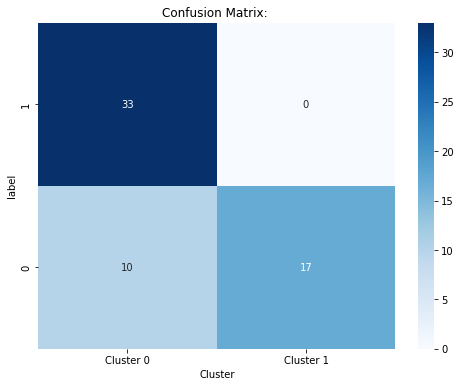

In [110]:
# Switch the 0 and 1 label to match the cluster label
url_sample_data['label'] = 1 - url_sample_data['label']

# Create a confusion matrix
conf_matrix = confusion_matrix(url_sample_data['label'], clusters_hc)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Cluster 0', 'Cluster 1'], yticklabels=['1','0'])
plt.xlabel('Cluster')
plt.ylabel('label')
plt.title('Confusion Matrix: ')
plt.show()

In [112]:
accuracy = (33+17)/(33+0+10+17)
print("Hierarchical Dendrogram Accuracy: {:.2f}%".format(accuracy*100))

Hierarchical Dendrogram Accuracy: 83.33%


### 6.1 Accuracy Chart

In [172]:
# Import Altair library
import altair as alt

# Phishing label accuracy chart
phishing_clusters = {'Method Name': ['K-Means 2 Clusters', 'K-Means 2 Clusters - SVD 18 PCs', 'Hierarchical 2 Clusters - Ward'],
                'Accuracy': [86.00, 86.32, 83.33]}

accuracy_chart_df = pd.DataFrame(phishing_clusters)

In [173]:
alt.Chart(accuracy_chart_df, title='Cluster Accuracy for Phishing Sites').mark_bar().encode(
    alt.X('Accuracy:Q', title = 'Accuracy (%)', scale=alt.Scale(domain=[0,100])),
    alt.Y('Method Name:N', sort='x'),
).properties(
    width=400,
    height=150
)

alt.Chart(...)